In [1]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

def get_link_data(src, dst, act, date='2017-08-01', span=1):
    es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
    DATE = date  # yyyy-mm-dd
    DELTA = span
    # Generate the indexes to scan
    dt.datetime.strptime(DATE,'%Y-%m-%d')
    index_list = []
    for i in range(-1, DELTA+1):
        index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                          + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
    #indexes = ','.join(index_list)
    indexes = 'fts_*'
    #print (index_list)
    period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
    period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=span)
    transfer_query = {
        "size": 0,
        "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
        'query':{
            "bool" : {
                "must" : [
                    {"term" : { "dst" : src }},
                    {"term" : { "src" : dst }},
                    {"term" : { "activity" : act }},
                    {"range" : {"transferred_at" : {  "gte": period_start } }},
                    {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                    ]
            }
        }

    }
    scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
    epoch = dt.datetime(1970,1,1)
    st = time.time()
    count = 0
    data = []
    for res in scroll:
        r = res['_source']
        #if not count%1000000 : print (count)
        r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
        count += 1
    #print('Reading took',time.time() - st,'seconds.')
    data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
    data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
    data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
    data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
    print('%d records retrieved for link %s --> %s (%s).' % (len(data), src, dst, act))
    return data
def holt_winters_second_order_ewma( x, span, beta ):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s[-1],b[-1]
def hwsoewma_forcast(s0, b0, beta, span):
    '''Forcast span values after s0'''
    s = [s0]
    b = [b0]
    queue_limit_time = 7*24*60*60  # 7 days in sec.
    for i in range(1,span):
        s.append(min((s[i-1] + i*b[i-1]),queue_limit_time))
        b.append(beta*(s[i] - s[i-1])+(1-beta)*b[i-1])
    return (s,b)

def calculate_ewma(window=12, beta=0.1):
    preds = []
    for t in data.index:
        history = cut[cut.index < t]
        history = history[history.index > history.index.max() - dt.timedelta(hours=windows)]
        if len(history) > 3:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s,b = hwsoewma_forcast(s0, b0, beta, 1)
            preds.append(max(s[0],-1))
        else:
            preds.append(-1)
    return preds


def make_prediction(data, window, every, beta):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        subcut = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        subcut = subcut[subcut.index > current]
        fspan = len(subcut)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        history = cut2[cut2.index < current]
        history = history[history.index > history.index.max() - dt.timedelta(hours=window)]
        if len(history) > 0:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s1,b = hwsoewma_forcast(s0, b0, beta, len(subcut))
            preds.extend(s1)
        else:
            preds.extend([-1]*len(subcut))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]


def make_prediction2(data, window, every, beta):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    # bin by minute
    y = []
    for second in cut1.index:
        y.append(cut1[cut1.index == second].Q_TIME.mean())
    cut1['Q_TIME'] = y
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        subcut = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        subcut = subcut[subcut.index > current]
        fspan = len(subcut)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        history = cut2[cut2.index < current]
        history = history[history.index > history.index.max() - dt.timedelta(hours=window)]
        if len(history) > 3:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s1,b = hwsoewma_forcast(s0, b0, beta, len(subcut))
            preds.extend(s1)
        else:
            preds.extend([-1]*len(subcut))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]

In [3]:
src = 'NDGF-T1'
dst = 'BNL-ATLAS'
act = 'Production Output'
#window in hours
window = .5
# recalculate every x minutes
every = 5
# the bigger the beta, the faster EWMA will react
beta=0.0001
data = get_link_data(src, dst, act,'2017-08-01', 7)
x1,y1,y_real1 = make_prediction(data, window, every, beta)

8994 records retrieved for link NDGF-T1 --> BNL-ATLAS (Production Output).


67.2417998584 89.2681102696


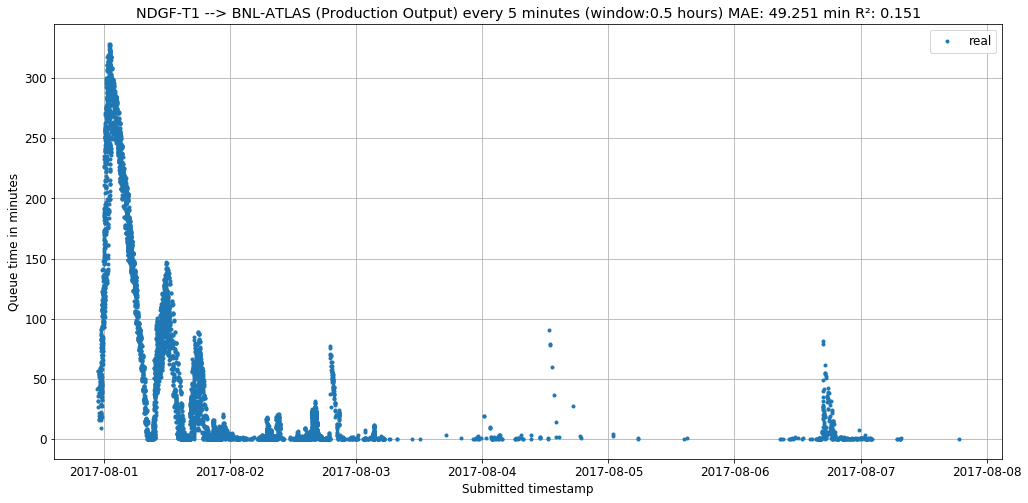

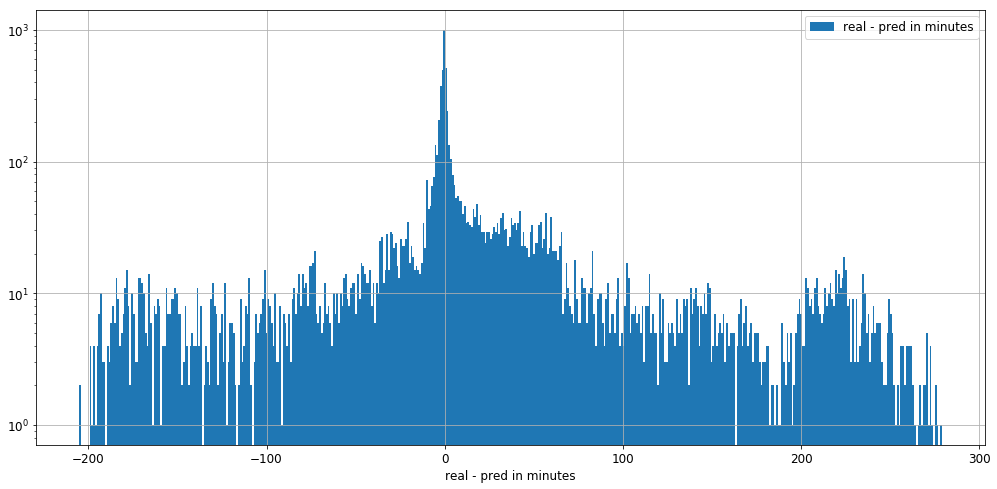

In [4]:
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s) every %d minutes (window:%.1f hours) MAE: %0.3f min R²: %0.3f'%
          (src,dst,act,every,window,mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.', label='predicted')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred in minutes',bins=500)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()